# RNN-seq2seq machine translation model with attention mechanism is built from scratch

Building a Seq2seq RNN for machine translation is also a natural language generation task. Seq2seq is a sequence-to-sequence model, similar to word-level RNNs

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Dataset/RNN_Dataset.zip

Archive:  /content/gdrive/MyDrive/Dataset/RNN_Dataset.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    # A dictionary that maps words to indexes
    self.word2index = {}
    # Count the total number of times each word appears
    self.word2count = {}
    # Mapping indexes to words
    self.index2word = {0: "SOS", 1: "EOS"}
    # The number of words in the dictionary
    self.n_words = 2

  def addSentence(self, sentence):
    """
    Devide the sentence into spaces
    and add each word in the sentence to the dictionary.
    """
    for word in sentence.split(" "):
      self.addWord(word)

  def addWord(self, word):
    """
    If the word has not appered before, it is added to the dictionary;
    If the word has appered before, the count is incremented by 1.
    """
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

In [ ]:
# Converting unicode encoding to plain ASCII encoding
def unicodeToAscii(s):
  return "".join(
      c for c in unicodedata.normalize("NFD", s)
      if unicodedata.category(c) != "Mn"
  )

# Lowercase, remove some characters that are not letters
def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r"\1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

/content/data/eng-fra.txt

In [ ]:
def readLang(lang1, lang2, reverse=False):
  print("Reading lines...")
  # Read in the file and press return to separate lines,
  # each of which is stored in lines
  lines = open(
      "data/%s-%s.txt" % (lang1, lang2), encoding="utf-8"
  ).read().strip().split("\n")

  # Each line, divided by tab, is in English
  # at the beginning and in French at the end
  pairs = [
    [normalizeString(s) for s in line.split("\t")] for line in lines
  ]

  # If reverse is True, it's French to English
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  # If reverse is False, it's English to French
  else:
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

  return input_lang, output_lang, pairs

In [ ]:
# The maximum sentence length is 10
MAX_LENGTH = 10
# Some sentences of length 10 or less starting with the following prefixes
# are filtered out as the traning set
eng_prefixes = (
    "i am", "i m",
    "he is", "he s"
    "she is", "she s"
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)

def filterPair(p):
  return len(p[0].split(" ")) < MAX_LENGTH and \
    len(p[1].split(" ")) < MAX_LENGTH and \
    p[1].startswith(eng_prefixes)

def filterPairs(pairs):
  return [ pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLang(lang1, lang2, reverse)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted Words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

In [ ]:
# French to English
input_lang, output_lang, pairs = prepareData("eng", "fra", True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10226 sentence pairs
Counting words...
Counted Words:
fra 5400
eng 3523
['il est l elu.', 'he is the chosen one.']


In [ ]:
# Create tensors of sentences
def indexesFromSentence(lang, sentence):
  return [
      lang.word2index[word] for word in sentence.split(" ")
  ]

# In the tensor of the sentence, EOS symbols are added
def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(
      indexes, dtype=torch.long, device=device
  ).view(-1, 1)

# Create tensors for sentence pairs
def tensorFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

In [ ]:
sample_pair = random.choice(pairs)
print(sample_pair)
input_tensor, target_tensor = tensorFromPair(sample_pair)
print("input: ", input_tensor)
print("target: ", target_tensor)

['je ne vais pas me disputer avec vous !', 'i m not going to argue with you.']
input:  tensor([[   5],
        [ 304],
        [   6],
        [ 305],
        [  24],
        [4582],
        [1131],
        [ 233],
        [  16],
        [   1]], device='cuda:0')
target:  tensor([[   2],
        [   3],
        [ 188],
        [ 541],
        [ 579],
        [2901],
        [ 722],
        [ 246],
        [   1]], device='cuda:0')


# GRU

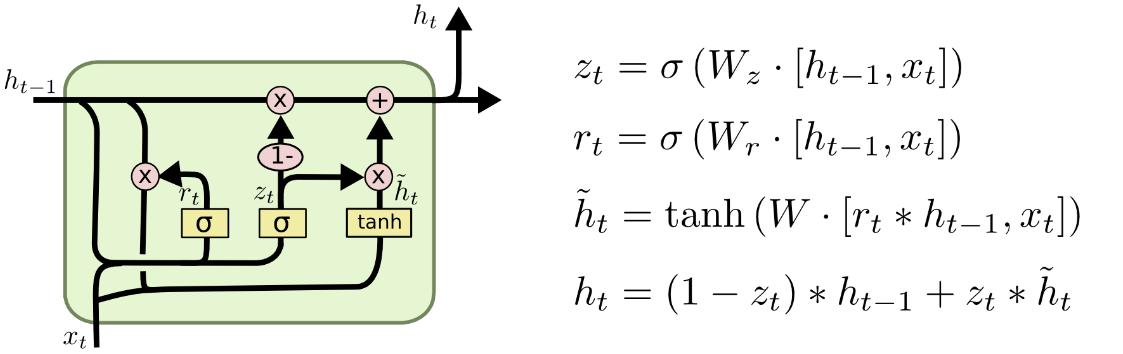

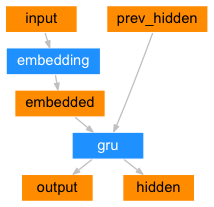

The embedding part onl work with discreated data set

- The first dimension, represents the batch size (that is, X sentences at a time)
- The second dimension, represents the sequence lengeth (that is, the current time step is a single word)
- The third dimension, represents the hidden size (that is, the length of the embedding vector)

In [ ]:
class EncoderGRU(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output, hidden = self.gru(embedded, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

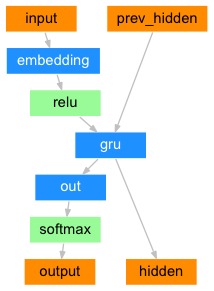

In [ ]:
class DecoderGRU(nn.Module):
  def __init__(self, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size. hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, output):
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = F.relu(embedded)
    output, hidden = self.gru(embedded, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

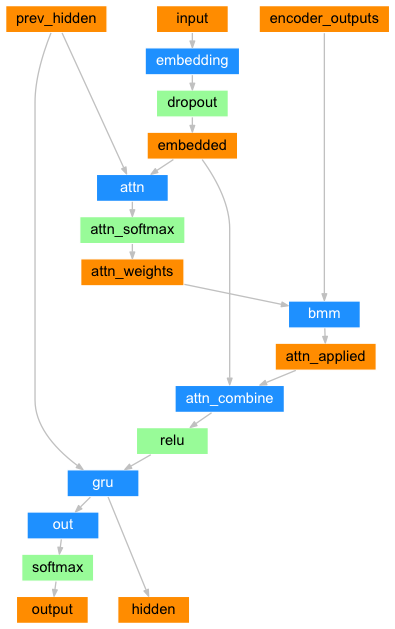

In [ ]:
class AttenDecoderGRU(nn.Module):
  def __init__(
      self, hidden_size, output_size,
      dropout_p=0.1, max_length=MAX_LENGTH
  ):
    super().__init__()
    self.hidden_size = hidden_size
    # Number of words in the target language
    self.output_size = output_size
    self.drouput_p = dropout_p
    self.max_length = max_length
    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size*2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
    self.dropout = nn.Dropout(self.drouput_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    # input is the previous output of the encoder or the actual previous word
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = self.dropout(embedded)

    # Computing attenton weights
    attn_weights = F.softmax(
        self.attn(torch.cat((embedded[0], hidden[0]), 1)),
        dim=1
    )

    # Compute the Hadamard probuct of two tensors
    # tensor a: attn_weights - (B, h, max_length)
    # tensor b: encoder_outputs - (B, max_length, h)
    # attn_applied: (1, 1, hidden_size)
    # HW - investigate this computing processing!!!
    attn_applied = torch.bmm(
        attn_weights.unsqueeze(0),
        encoder_outputs.unsqueeze(0)
    )
    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
teacher_forcing_ratio = 0.5

def train(
    input_tensor, target_tensor,
    encoder, decoder,
    encoder_optimizer, decoder_optimizer,
    criterion, max_length=MAX_LENGTH
):
  encoder_hidden = encoder.initHidden()
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  # Source language sentence length
  input_length = input_tensor.size(0)
  # Target language sentence length
  target_lenth = target_tensor.size(0)
  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
  loss = 0

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden
    )
    # Save the hidden state of the encoder at each step
    encoder_outputs[ei] = encoder_output[0, 0]

  # The first input to decoder is SOS
  decoder_input = torch.tensor([[SOS_token]], device=device)
  # encoder hides layer states in the last step
  decoder_hidden = encoder_hidden

  # HW - analysis of this technology!!!
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  if use_teacher_forcing:
    # Forch the input of the target
    for di in range(target_lenth):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs
      )
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]
  else:
    # Enter the predicted input
    for di in range(target_lenth):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs
      )
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()
      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token: break

  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.stem()

  return loss.item() / target_lenth

In [ ]:
import time
import math

def asMinutes(a):
  m = math.floor(s / 60)
  s -= m * 60
  return "%dm %ds" % (m, s)

def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / percent
  rs = es - s
  return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaixs.set_major_locator(loc)
  plt.plot(points)

In [ ]:
def tarinIters(
    encoder, decoder, n_iters,
    print_every=1000, plot_every=100,
    learning_rate=0.01
):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
  training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(n_iters)]
  criterion = nn.NLLLoss

  for iter in range(1, n_iters+1):
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    loss = train(
        input_tensor, target_tensor, encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )
    print_loss_total += 1
    plot_loss_total += 1

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print(
          "%s (%d %d%%) %.4f" % (
              timeSince(start, iter/n_iters),
              iter,
              iter / n_iters * 100,
              print_loss_avg
          )
      )
    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

  showPlot(plot_losses)

hidden_size = 256
encoder = EncoderGRU(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttenDecoderGRU(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

tarinIters(encoder, attn_decoder, 1000000, print_every=5000)

KeyboardInterrupt: 

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_length, encoder, hidden_size, device=device)
    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoded_words =[]
    decoder_attentions = torch.zeros(max_length, max_length)
    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs
      )
      decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == EOS_token:
        decoded_words.append("<EOS>")
        break
      else:
        decoded_words.append(output_lang.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()
    return decoded_words, decoder_attentions[:di+1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print(">" pair[0])
    print("=", pair[1])
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = " ".join(output_words)
    print("<", output_sentence)
    print()

evaluateRandomly(encoder, attn_decoder)

In [ ]:
output_words, attentions = evaluate(
    encoder, attn_decoder, "XXXX"
)
plt.matshow(attentions.cpu().numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
  # Set up figure with colorbar
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.numpy(), cmap="bone")
  fig.colorbar(cax)
  # Set up axes
  ax.set_xticklabels([""] + input_sentence.split(' ') + ["<EOS>"], rotation=90)
  ax.set_yticklabels([""] + output_words)
  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

def evaluateAndShowAttention(input_sentence):
  output_words, attention = evaluate(
      encoder, attn_decoder, input_sentence
  )
  print("input: ", input_sentence)
  print("output: ", " ".join(output_words))
  showAttention(input_sentence, output_words, attentions)